goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from math import floor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def get_random_folders(base_dir: str, split_interval_secs: int | float, total_folders: int = 50, sample_rate: int = 32000, file_cutoff: int = 2000, folder_cutoff: int = 25, all_folder_files: bool = False, folder_size_range: tuple = (0, 0)):
    folders = os.listdir(base_dir)
    folder_count = 0
    random.shuffle(folders)

    rows = []

    for folder in folders:
        folder_dir = base_dir + folder + "/"

        folder_files = 0
        if folder_size_range != (0, 0):
            size = len(os.listdir(folder_dir))
            if size < folder_size_range[0] or size > folder_size_range[1]:
                continue

        for file in (progress_bar := tqdm(os.listdir(folder_dir))):
            file_data, file_sample_rate_hz = librosa.load(folder_dir + file, sr=sample_rate)

            total_splits = floor((len(file_data) / file_sample_rate_hz) / split_interval_secs) # floor(file length / split interval)

            if total_splits >= 1:
                split_size = int(file_sample_rate_hz * split_interval_secs)

                for split_offset in range(0, file_sample_rate_hz * total_splits + 1, split_size):
                    file_split_data = file_data[split_offset : split_offset + split_size]

                    spec_data = np.abs(librosa.stft(file_split_data)) # convert file data into mel-spectrogram fourier transform for feeding into CNN

                    row = [folder, file, len(file_split_data), file_sample_rate_hz, split_interval_secs, spec_data]
                    rows.append(row)

                    folder_files += 1
                
            if folder_files >= 200 and not all_folder_files: break
            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")

        folder_count += 1

        if len(rows) >= file_cutoff and folder_count >= folder_cutoff and not all_folder_files: 
            print(f"Enumeration ended early due to having over {file_cutoff} files and at least {folder_cutoff} classes.")
            break

        if all_folder_files and folder_count >= total_folders: 
            break

    folder_df = pd.DataFrame(data=rows, columns=["folder", "file", "samples", "sample_rate_hz", "file_length_secs", "stft_data"])

    return folder_df

In [4]:
base_dir = "../datasets/birdsongs-combined/train_audio/"

# load the entire file and split the data. (interval of 10 seconds?) (remove anything that is under 10 seconds long)
split_interval_secs = 2 # change this as you please. CAN be a float i think?
sample_rate = 32000

# load 50 random files, cut off after 25 folders and 2000 files
#folder_df = get_random_folders(base_dir, split_interval_secs=2, total_folders=50, sample_rate=sample_rate, file_cutoff=2000, folder_cutoff=25)

# load ALL files from 10 random folders.
# prevent under/oversampling by setting a range of files per folder
folder_df = get_random_folders(base_dir, split_interval_secs=split_interval_secs, total_folders=10, sample_rate=sample_rate, all_folder_files=True, folder_size_range=(50,100))

Folder 10/10 - hoowar: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


In [5]:
len(folder_df)

12499

In [6]:
len(folder_df["folder"].unique())

10

<Axes: xlabel='folder'>

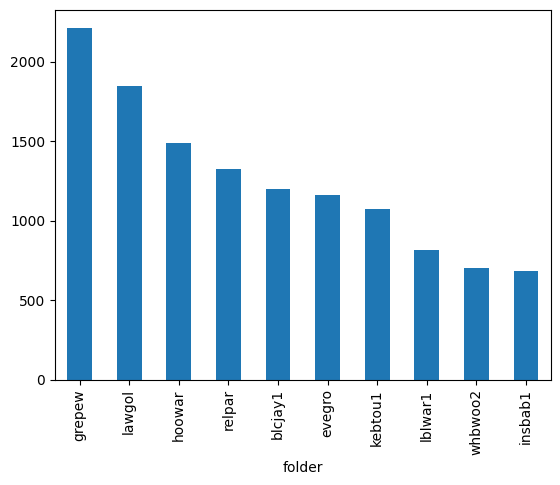

In [7]:
folder_df["folder"].value_counts().plot.bar()

In [8]:
# apply random undersampling OR oversampling

sampling_technique = "over"

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

In [9]:
mel_specs = []
mel_spec_shapes = []

for i in tqdm(folder_df.index):
    row = folder_df.iloc[i, :]

    spec_magnitude, _ = librosa.magphase(row["stft_data"])
    mel_scale_spectrogram = librosa.feature.melspectrogram(S=spec_magnitude, sr=row["sample_rate_hz"])
    mel_scale_spectrogram_db = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)

    mel_specs.append(mel_scale_spectrogram_db)
    mel_spec_shapes.append(mel_scale_spectrogram_db.shape)

folder_df["mel_spec"] = mel_specs
folder_df["mel_spec_shape"] = mel_spec_shapes

del mel_specs, i, row, spec_magnitude, mel_scale_spectrogram, mel_scale_spectrogram_db, mel_spec_shapes

100%|██████████| 22140/22140 [01:11<00:00, 308.30it/s]


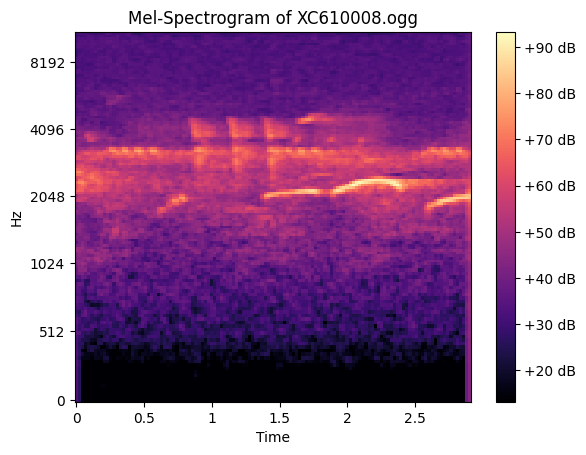

In [10]:
row = folder_df.iloc[random.randint(0, len(folder_df)), :]

plt.figure()
librosa.display.specshow(row["mel_spec"], x_axis="time", y_axis="mel")
plt.title(f"Mel-Spectrogram of {row["file"]}")
plt.colorbar(format='%+2.0f dB')
plt.show()

del row

In [11]:
# mel_spec_shape's x value is ALWAYS 128.

In [12]:
folder_df[["file_length_secs", "mel_spec_shape"]].value_counts()

# all of the same shape WHEN:
# - all file lengths are the same (customise interval at will)
# - sample rate is controlled. (e.g. 32000hz)

# 10 second file length + 32000 sampling rate = (128, 626) input shape
# 2 second file length + 32000 sampling rate = (128, 126) input shape

file_length_secs  mel_spec_shape
2                 (128, 126)        22140
Name: count, dtype: int64

In [13]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)

x = np.array([[j.tolist() for j in i] for i in folder_df["mel_spec"]])
x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
x = torch.FloatTensor(x)
x = x.to(device)

le = LabelEncoder()
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
y = y.to(device)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.3, random_state=1368)

In [15]:
# create machine learning model.

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")

        # define layers here
        # assuming input shape = 1x128x126

        # conv2d: 1x128x126 -> 1x124x124 (kernel size = (5,3))
        # relu
        # max pool: 1x124x124 -> 1x62x62 (pool size = (2,2))
        # conv2d: 1x62x62 -> 1x60x60 (kernel size = (3, 3))
        # relu
        # max pool: 1x60x60 -> 1x30x30 (pool size = (2, 2))
        # flatten: 1x30x30 -> 900
        # linear: 900 -> 128
        # linear: 128 -> 32
        # linear: 32 -> (output layers)

        self.conv1 = nn.Conv2d(in_channels=input_shape[1], out_channels=1, kernel_size=(5, 3))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=900, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=32) 
        self.output = nn.Linear(in_features=32, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output(x)

        return x

In [16]:
def train_model(model, loss_fn, optimizer, epochs, batch_size):
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}%")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

    print(model)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} files over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist

Epoch 1: train loss = 2.3128, train acc = 10.39%, test acc = 10.43%
Epoch 2: train loss = 2.2890, train acc = 12.72%, test acc = 15.39%
Epoch 3: train loss = 2.1770, train acc = 17.94%, test acc = 20.36%
Epoch 4: train loss = 2.0222, train acc = 26.53%, test acc = 28.64%
Epoch 5: train loss = 1.8025, train acc = 36.75%, test acc = 39.96%
Epoch 6: train loss = 1.5975, train acc = 45.43%, test acc = 46.43%
Epoch 7: train loss = 1.4674, train acc = 50.10%, test acc = 49.83%
Epoch 8: train loss = 1.3850, train acc = 53.15%, test acc = 52.63%
Epoch 9: train loss = 1.3281, train acc = 55.53%, test acc = 54.61%
Epoch 10: train loss = 1.2811, train acc = 57.21%, test acc = 55.69%
Epoch 11: train loss = 1.2381, train acc = 58.42%, test acc = 56.64%
Epoch 12: train loss = 1.1940, train acc = 59.63%, test acc = 57.77%
Epoch 13: train loss = 1.1481, train acc = 60.85%, test acc = 58.70%
Epoch 14: train loss = 1.1018, train acc = 61.82%, test acc = 59.41%
Epoch 15: train loss = 1.0585, train acc = 

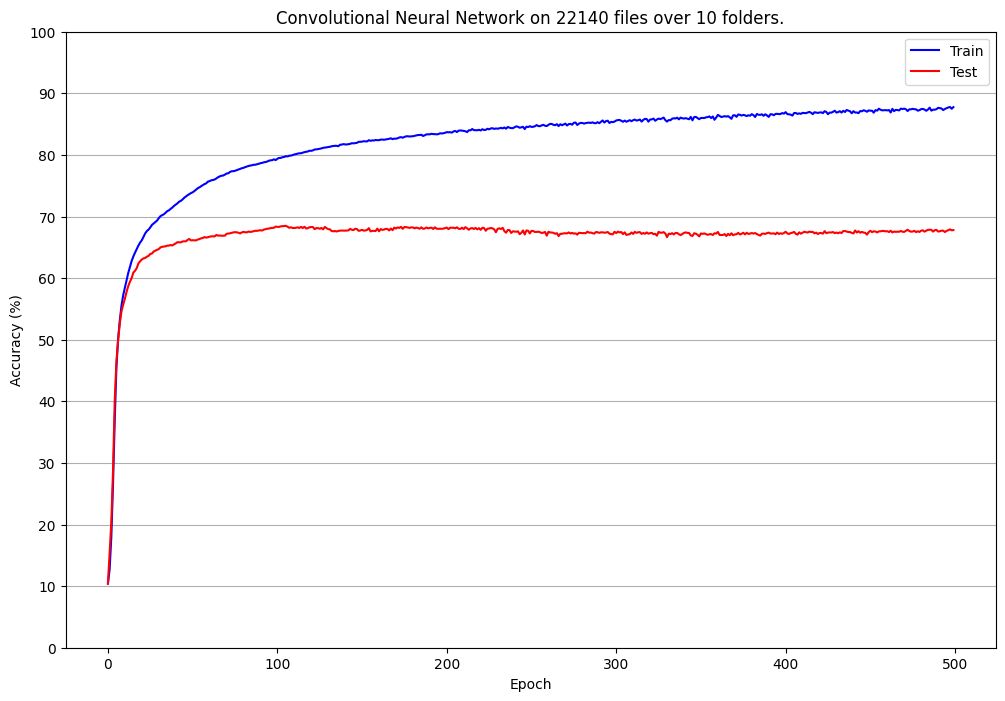

([2.3128371238708496,
  2.2889719009399414,
  2.177020311355591,
  2.022228479385376,
  1.8024662733078003,
  1.5975396633148193,
  1.467421531677246,
  1.3850305080413818,
  1.3280785083770752,
  1.2810726165771484,
  1.2381433248519897,
  1.1939910650253296,
  1.1480931043624878,
  1.1017718315124512,
  1.0584934949874878,
  1.0216120481491089,
  0.990462064743042,
  0.9644023180007935,
  0.9424908757209778,
  0.9230900406837463,
  0.9071443676948547,
  0.892786979675293,
  0.8795886039733887,
  0.8686553835868835,
  0.8583347201347351,
  0.849964439868927,
  0.8419034481048584,
  0.8346213698387146,
  0.8267525434494019,
  0.8209855556488037,
  0.8155837655067444,
  0.8103801012039185,
  0.8057690262794495,
  0.8017140626907349,
  0.7973263263702393,
  0.7935826182365417,
  0.7896131277084351,
  0.7857464551925659,
  0.782676100730896,
  0.7789983749389648,
  0.7747288346290588,
  0.7722348570823669,
  0.7677956223487854,
  0.7644395232200623,
  0.7602109909057617,
  0.7562956809997

In [20]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

epochs = 500
batch_size = 64
dropout_rate = 0
learning_rate = 0.001
momentum = 0

model = TestModel(input_shape=x.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum)

train_model(model, loss_fn, optimizer, epochs, batch_size)

In [18]:
# final results after testing approx. 30 different variations of dropout, learning rate, etc
# best learning rate = 0.001, batch size of 32/64, dropout rate around 0.2-0.5
# 200 epochs gives best results as test acc plateaus after that, prevents overfitting
# train/test split between 20-30% gives good results

In [19]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)